In [1]:
!pip install keras-tuner --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.8 MB/s eta 0:00:00


In [2]:
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download -d pcbreviglieri/smart-grid-stability

 64% 4.00M/6.30M [00:01<00:00, 4.69MB/s]
100% 6.30M/6.30M [00:01<00:00, 4.97MB/s]


In [4]:
! unzip /content/smart-grid-stability.zip

Archive:  /content/smart-grid-stability.zip
  inflating: smart_grid_stability_augmented.csv  


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm 
import seaborn as sn
from sklearn import metrics, preprocessing, model_selection
import keras_tuner as kt

# Read the Data

In [6]:
dataset = pd.read_csv('/content/smart_grid_stability_augmented.csv')
dataset 

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,unstable
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,stable
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,-0.031810,stable
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,unstable


In [7]:
# drop the stab column
dataset.drop(columns=['stab'],inplace=True)

In [8]:
# show the dataset information 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stabf   60000 non-null  object 
dtypes: float64(12), object(1)
memory usage: 6.0+ MB


# Preprocessing the Dataset 

In [9]:
# drop the na values 
dataset.dropna(inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 59999
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stabf   60000 non-null  object 
dtypes: float64(12), object(1)
memory usage: 6.4+ MB


In [10]:
dataset

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,unstable
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,stable
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,stable
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,unstable


array([[<AxesSubplot:title={'center':'tau1'}>,
        <AxesSubplot:title={'center':'tau2'}>,
        <AxesSubplot:title={'center':'tau3'}>],
       [<AxesSubplot:title={'center':'tau4'}>,
        <AxesSubplot:title={'center':'p1'}>,
        <AxesSubplot:title={'center':'p2'}>],
       [<AxesSubplot:title={'center':'p3'}>,
        <AxesSubplot:title={'center':'p4'}>,
        <AxesSubplot:title={'center':'g1'}>],
       [<AxesSubplot:title={'center':'g2'}>,
        <AxesSubplot:title={'center':'g3'}>,
        <AxesSubplot:title={'center':'g4'}>]], dtype=object)

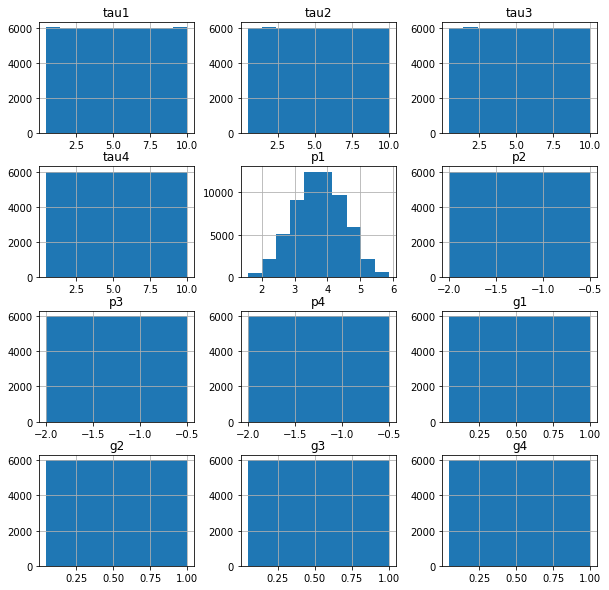

In [11]:
# plot the histogram 
dataset.hist(figsize=(10,10))

In [12]:
dataset.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,5.250000,5.250001,5.250001,5.250001,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000
std,2.742434,2.742437,2.742437,2.742437,0.752129,0.433017,0.433017,0.433017,0.274244,0.274243,0.274243,0.274243
min,0.500793,0.500141,0.500141,0.500141,1.582590,-1.999945,-1.999945,-1.999945,0.050009,0.050028,0.050028,0.050028
25%,2.874892,2.875011,2.875011,2.875011,3.218300,-1.624997,-1.624997,-1.624997,0.287521,0.287497,0.287497,0.287497
50%,5.250004,5.249981,5.249981,5.249981,3.751025,-1.249996,-1.249996,-1.249996,0.525009,0.525007,0.525007,0.525007
75%,7.624690,7.624896,7.624896,7.624896,4.282420,-0.874993,-0.874993,-0.874993,0.762435,0.762490,0.762490,0.762490
max,9.999469,9.999837,9.999837,9.999837,5.864418,-0.500025,-0.500025,-0.500025,0.999937,0.999982,0.999982,0.999982


In [13]:
dataset

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,unstable
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,stable
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,stable
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,unstable


In [14]:
dataset.iloc[0]

tau1      2.95906
tau2     3.079885
tau3     8.381025
tau4     9.780754
p1       3.763085
p2      -0.782604
p3      -1.257395
p4      -1.723086
g1       0.650456
g2       0.859578
g3       0.887445
g4       0.958034
stabf    unstable
Name: 0, dtype: object

In [15]:

dataset.stabf=dataset.stabf.factorize()[0]

array([[<AxesSubplot:title={'center':'tau1'}>,
        <AxesSubplot:title={'center':'tau2'}>,
        <AxesSubplot:title={'center':'tau3'}>,
        <AxesSubplot:title={'center':'tau4'}>],
       [<AxesSubplot:title={'center':'p1'}>,
        <AxesSubplot:title={'center':'p2'}>,
        <AxesSubplot:title={'center':'p3'}>,
        <AxesSubplot:title={'center':'p4'}>],
       [<AxesSubplot:title={'center':'g1'}>,
        <AxesSubplot:title={'center':'g2'}>,
        <AxesSubplot:title={'center':'g3'}>,
        <AxesSubplot:title={'center':'g4'}>],
       [<AxesSubplot:title={'center':'stabf'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

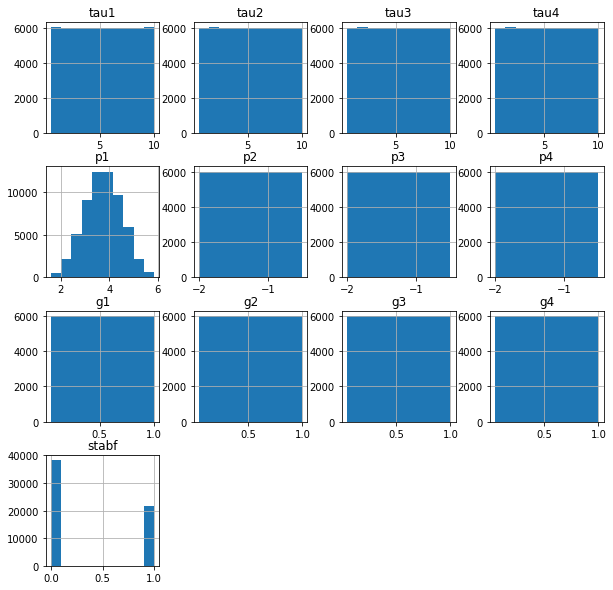

In [16]:
# plot the histogram 
dataset.hist(figsize=(10,10))

In [17]:
new_dataset=dataset[dataset.stabf==1].iloc[:5000,:]
new_dataset = new_dataset.append(dataset[dataset.stabf==0].sample(n=len(new_dataset.stabf)))
new_dataset

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,1
5,6.999209,9.109247,3.784066,4.267788,4.429669,-1.857139,-0.670397,-1.902133,0.261793,0.077930,0.542884,0.469931,1
8,4.689852,4.007747,1.478573,3.733787,4.041300,-1.410344,-1.238204,-1.392751,0.269708,0.250364,0.164941,0.482439,1
10,5.930110,6.730873,6.245138,0.533288,2.327092,-0.702501,-1.116920,-0.507671,0.239816,0.563110,0.164461,0.753701,1
12,1.616787,2.939228,0.819791,4.191804,3.752282,-1.484885,-1.280581,-0.986816,0.899698,0.866546,0.303921,0.077610,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3530,8.281845,7.892805,6.792521,4.004448,2.659413,-0.540454,-1.066195,-1.052764,0.935774,0.519607,0.395720,0.134011,0
32685,5.115633,5.711873,6.254407,5.845662,4.222533,-1.320746,-1.579720,-1.322067,0.449611,0.208084,0.656163,0.942931,0
32938,8.821837,8.591700,4.080953,3.752681,4.878826,-1.494623,-1.643219,-1.740985,0.167796,0.673848,0.743382,0.676407,0
39100,5.139775,1.803945,1.985586,5.466503,3.942891,-1.817266,-0.770232,-1.355393,0.844655,0.982531,0.765703,0.387863,0


In [18]:
# split the data to features and labels 
x=new_dataset.iloc[:,:-1]
y=new_dataset.iloc[:,-1]

In [19]:
# scale the feature values between 0,1
min_max_preprocess =preprocessing.StandardScaler()
min_max_preprocess.fit(x)
x_norm=min_max_preprocess.transform(x)


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>],
       [<AxesSubplot:title={'center':'9'}>,
        <AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>]], dtype=object)

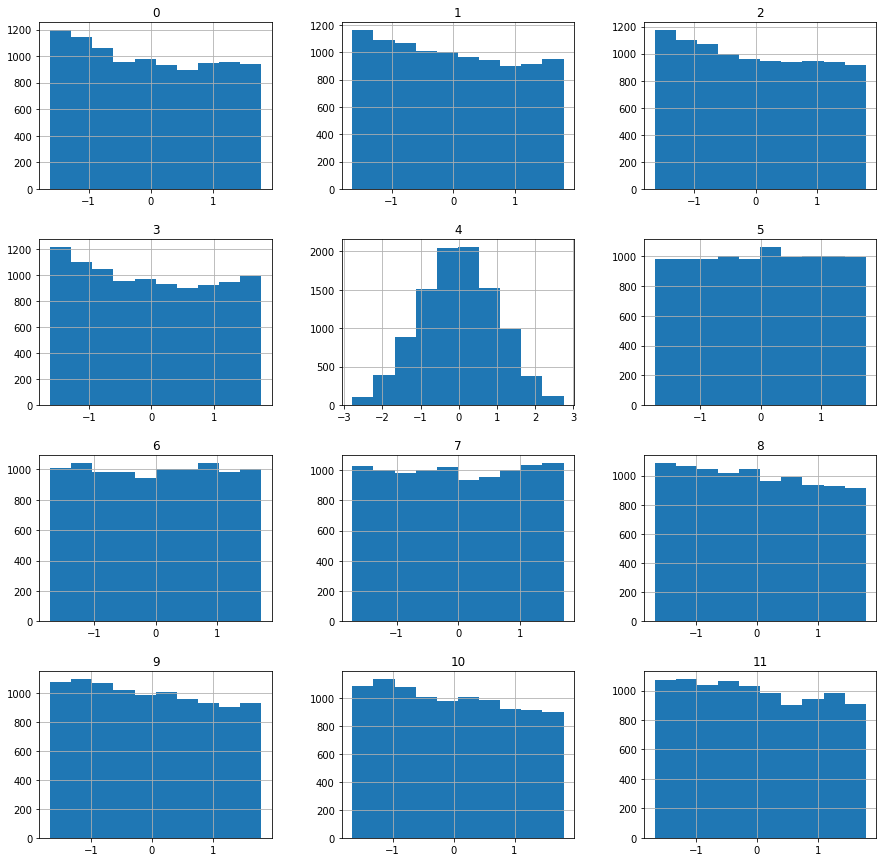

In [20]:
pd.DataFrame(x_norm).hist(figsize=(15,15))

(array([5000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

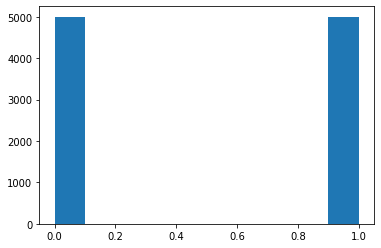

In [21]:
plt.hist(y)

# Spilt the Data to Train & Test 

In [22]:
x_train,x_test,y_train,y_test = model_selection.train_test_split(x_norm,y,test_size=0.1,random_state=42,stratify=y)

# Create the Data Pipeline

In [23]:
# creat the data pipeline
def data_pipeline(x,y,batch_size=32):
    # insert the data to the data pipeline
    data=tf.data.Dataset.from_tensor_slices((x,y))
    data=data.shuffle(50000)# shuffle the data
    data=data.batch(batch_size)# creat the batch
    data=data.prefetch(tf.data.AUTOTUNE)# run the data processing and training in parallel 
    return data

In [24]:
# create the train pipeline 
train_dataset=data_pipeline(x_train,y_train)
# create the test pipeline
test_dataset=data_pipeline(x_test,y_test)

In [25]:
# get the first batch of data from the train pipeline 
for x,y in train_dataset.take(1):
    print(x)
    print(y)

tf.Tensor(
[[ 1.16318358 -0.11765525 -0.87938635  1.18623466 -0.49199043  0.34030656
   0.86452817 -0.34756164 -0.47676177 -1.4904523   0.57704407 -0.17951974]
 [ 0.61725687 -1.35171875 -1.19982929 -0.21677685 -0.88652738  1.61867548
   1.22457042 -1.28653485  1.23254369  1.68996503  1.72516821 -1.31925167]
 [ 0.20906047 -1.51192421  0.49120023 -1.41817909  0.11987073  0.49434159
  -1.43488956  0.73282777  1.08823125 -0.39297548  1.74460964  1.25501984]
 [-1.07331769 -0.85899873 -1.15969929 -0.95088091 -0.68252957  1.13428541
  -0.60221511  0.65632689  0.14726195 -1.26215401  0.54981817  1.06882308]
 [-0.46371712  0.62496024  1.45287994 -0.47012997  0.94485672  0.42046619
  -1.19116131 -0.85831621  0.54277225 -0.74451445  0.35533129  0.36473599]
 [-1.32876356  1.02029116  0.92351096 -0.47037421 -1.90481642  1.62678454
   0.75655315  0.92561978 -0.20529538  1.51488979 -0.16532267 -1.01083256]
 [-0.33924586  0.17015137  0.36567451  0.69108415  1.66664689 -0.24177285
  -1.41060867 -1.2307

# Model

In [26]:
class Model(tf.keras.Model):
    def __init__(self,units_tuner,activation_tuner,kernel_regularizer_tuner,dropout_tuner):
        super(Model,self).__init__()
        self.dropout_tuner=dropout_tuner
        activation_tuner=[tf.nn.relu,tf.nn.leaky_relu,tf.nn.elu][activation_tuner]


        self.D1=tf.keras.layers.Dense(units_tuner[0],activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[0],name='D1')
        self.D1_dropout = tf.keras.layers.Dropout(0.3)
        self.D2=tf.keras.layers.Dense(units_tuner[1],activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[1],name='D2')
        self.D2_dropout = tf.keras.layers.Dropout(0.3)
        self.D3=tf.keras.layers.Dense(units_tuner[2],activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[2],name='D3')
        self.D3_dropout = tf.keras.layers.Dropout(0.3)
        self.D4=tf.keras.layers.Dense(units_tuner[3],activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[3],name='D4')
        self.D4_dropout = tf.keras.layers.Dropout(0.3)
        self.D5=tf.keras.layers.Dense(units_tuner[4],activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[4],name='D5')
        self.D5_dropout = tf.keras.layers.Dropout(0.3)
        self.out=tf.keras.layers.Dense(1,activation=tf.nn.sigmoid,name='out')
    def call(self,x ):
        x=self.D1(x)
        if self.dropout_tuner:
            x=self.D1_dropout(x)
        x=self.D2(x)
        if self.dropout_tuner:
            x=self.D2_dropout(x)
        x=self.D3(x)
        if self.dropout_tuner:
            x=self.D3_dropout(x)
        x=self.D4(x)
        if self.dropout_tuner:
            x=self.D4_dropout(x)
        x=self.D5(x)
        if self.dropout_tuner:
            x=self.D5_dropout(x)
        out = self.out(x)
        return out


In [27]:
def model_builder(hp):
    # define the kernel values tuner 
    units_tuner=[hp.Int('D1', min_value=8, max_value=512, step=32),
                  hp.Int('D2', min_value=8, max_value=512, step=32),
                  hp.Int('D3', min_value=8, max_value=512, step=32),
                  hp.Int('D4', min_value=8, max_value=512, step=32),
                  hp.Int('D5', min_value=8, max_value=512, step=32)]
                 
    # define the activation function tuner 
    activation_tuner = hp.Choice('activation',[0,1,2])

    # define the kernel_regularizer_tuner
    kernel_regularizer_tuner=[hp.Choice('regularizer_1',['L1','L2','L1L2']),
                              hp.Choice('regularizer_2',['L1','L2','L1L2']),
                              hp.Choice('regularizer_3',['L1','L2','L1L2']),
                              hp.Choice('regularizer_4',['L1','L2','L1L2']),
                              hp.Choice('regularizer_5',['L1','L2','L1L2']),
                              ]
    # define the dropout_tuner
    dropout_tuner= hp.Choice('dropout',[True,False])
    
    
    model = Model(
                      units_tuner=units_tuner,
                      activation_tuner=activation_tuner,
                      kernel_regularizer_tuner=kernel_regularizer_tuner,
                      dropout_tuner=dropout_tuner,
                     
                      )
    
    model.build((None,12))# build the model 
    
    # define the learning rate tuner 
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # compile the model 
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"]
    )
    return model 

In [28]:
tuner = kt.BayesianOptimization(model_builder,
                     objective='val_loss',
                     max_trials=10,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [29]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [30]:
tuner.search(train_dataset, epochs=50,validation_data=test_dataset , callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 10 Complete [00h 00m 23s]
val_loss: 0.29295703768730164

Best val_loss So Far: 0.13564792275428772
Total elapsed time: 00h 07m 24s


In [31]:
a=tuner.get_best_hyperparameters()[0]
a.values

{'D1': 104,
 'D2': 328,
 'D3': 264,
 'D4': 456,
 'D5': 200,
 'activation': 0,
 'regularizer_1': 'L2',
 'regularizer_2': 'L1L2',
 'regularizer_3': 'L1L2',
 'regularizer_4': 'L1L2',
 'regularizer_5': 'L1L2',
 'dropout': 1,
 'lr': 0.0012625225902271942}

## Model Evaluation 

In [32]:
#Get optimal hyperparameters and models from the tuner
model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 D1 (Dense)                  multiple                  1352      
                                                                 
 dropout_5 (Dropout)         multiple                  0         
                                                                 
 D2 (Dense)                  multiple                  34440     
                                                                 
 dropout_6 (Dropout)         multiple                  0         
                                                                 
 D3 (Dense)                  multiple                  86856     
                                                                 
 dropout_7 (Dropout)         multiple                  0         
                                                                 
 D4 (Dense)                  multiple                  1208

In [34]:
model.fit(train_dataset,epochs=50,validation_data=test_dataset)

Epoch 1/50
282/282 [==============================] - 4s 5ms/step - loss: 0.5419 - accuracy: 0.8059 - val_loss: 0.3229 - val_accuracy: 0.9100
Epoch 2/50
282/282 [==============================] - 1s 4ms/step - loss: 0.3557 - accuracy: 0.8767 - val_loss: 0.2101 - val_accuracy: 0.9400
Epoch 3/50
282/282 [==============================] - 1s 4ms/step - loss: 0.2831 - accuracy: 0.9030 - val_loss: 0.1879 - val_accuracy: 0.9360
Epoch 4/50
282/282 [==============================] - 1s 5ms/step - loss: 0.2444 - accuracy: 0.9147 - val_loss: 0.1740 - val_accuracy: 0.9510
Epoch 5/50
282/282 [==============================] - 1s 4ms/step - loss: 0.2419 - accuracy: 0.9131 - val_loss: 0.1541 - val_accuracy: 0.9490
Epoch 6/50
282/282 [==============================] - 1s 4ms/step - loss: 0.2243 - accuracy: 0.9214 - val_loss: 0.1501 - val_accuracy: 0.9520
Epoch 7/50
282/282 [==============================] - 1s 4ms/step - loss: 0.2271 - accuracy: 0.9164 - val_loss: 0.1535 - val_accuracy: 0.9560
Epoch 

<AxesSubplot:>

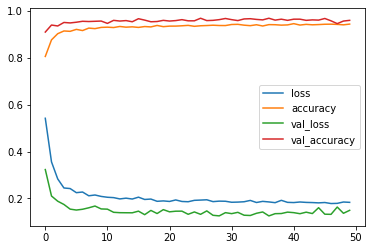

In [35]:
pd.DataFrame(model.history.history).plot()

In [36]:
preds=np.array([])
ys=np.array([])
for x,y in tqdm.tqdm(test_dataset):
    pred = model.predict(x)
    preds=np.append(preds,pred)
  
    ys=np.append(ys,y)
    
    
    
    

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 126ms/step


  3%|▎         | 1/32 [00:00<00:06,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 3/32 [00:00<00:02, 10.40it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 5/32 [00:00<00:02, 13.16it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 7/32 [00:00<00:01, 13.79it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 9/32 [00:00<00:01, 15.44it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 11/32 [00:00<00:01, 15.95it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 13/32 [00:00<00:01, 17.02it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 15/32 [00:01<00:01, 16.54it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 17/32 [00:01<00:00, 17.27it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 19/32 [00:01<00:00, 17.43it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 21/32 [00:01<00:00, 17.22it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 23/32 [00:01<00:00, 17.64it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 25/32 [00:01<00:00, 17.67it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 27/32 [00:01<00:00, 18.13it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 29/32 [00:01<00:00, 18.40it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 31/32 [00:01<00:00, 18.30it/s]

1/1 [==============================] - 0s 91ms/step


100%|██████████| 32/32 [00:02<00:00, 15.64it/s]


In [37]:
 preds = preds>0.5
 preds=preds.astype(int)

In [38]:
preds.shape

(1000,)

accuracy_score: 0.96
precision_score: 0.9604715228393875
recall_score: 0.96
f1_score: 0.9599897573778887


<AxesSubplot:>

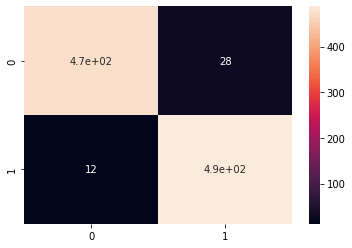

In [39]:
accuracy_score=metrics.accuracy_score(y_true=ys,y_pred=preds)
precision_score=metrics.precision_score(ys,preds,average='weighted')
recall_score=metrics.recall_score(ys,preds,average='weighted')
f1_score=metrics.f1_score(ys,preds,average='weighted')
confion_metrix=metrics.confusion_matrix(ys,preds)
print('accuracy_score:',accuracy_score)
print('precision_score:',precision_score)
print('recall_score:',recall_score)
print('f1_score:',f1_score)
sn.heatmap(confion_metrix,annot=True,)